## Importing Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from scipy.stats import qmc
import random
import matplotlib
import matplotlib.lines as mlines


# Set global parameters
matplotlib.rcParams.update({
    'font.size': 12,  # Adjust font size
    'figure.dpi': 300  # Set high resolution for the plot
})


seed = 42
random.seed(seed)
np.random.seed(seed)

## Basic Fully-Connected Network

In [2]:
class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super(FCN, self).__init__()
        activation = nn.Tanh

        # Input layer
        self.fcs = nn.Sequential(nn.Linear(N_INPUT, N_HIDDEN), activation())

        # Hidden layers
        hidden_layers = [nn.Sequential(nn.Linear(N_HIDDEN, N_HIDDEN), activation()) for _ in range(N_LAYERS-1)]
        self.fch = nn.Sequential(*hidden_layers)

        # Output layer
        self.fce = nn.Linear(N_HIDDEN, N_OUTPUT)

    def forward(self, x):
        x = self.fcs(x)
        for hidden_layer in self.fch:
            x = hidden_layer(x)
        x = self.fce(x)
        return x

# Example usage
N_INPUT = 3
N_OUTPUT = 1
N_HIDDEN = 20
N_LAYERS = 5

pinn = FCN(N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS)
optimiser = torch.optim.Adam(pinn.parameters(), lr=1e-3)

## Training

In [3]:
def init_xavier(model, retrain_seed=42):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

def D(phi, epsilon):
  output = torch.where(phi.abs() < epsilon, 1., 0.)
  return output

init_xavier(pinn, seed)

In [3]:
# Constants
X, Y, T = 1.1, 0.2, 0.5  # domain limits
u = 2
v = 0

N_x = 55
N_y = 10
N_t = 50

resolution = X/N_x
epsilon = (1.01/2)*resolution

# Physics collocation points
t_values = torch.linspace(0, T, N_t).view(-1, 1)
x_values = torch.linspace(0, X, N_x).view(-1, 1)
y_values = torch.linspace(0, Y, N_y).view(-1, 1)

t_physics, x_physics, y_physics = torch.meshgrid(t_values[:, 0], x_values[:, 0], y_values[:, 0], indexing='ij')

# Flatten the grid to pass through the network
t_physics = t_physics.reshape(-1, 1).requires_grad_(True)
x_physics = x_physics.reshape(-1, 1).requires_grad_(True)
y_physics = y_physics.reshape(-1, 1).requires_grad_(True)

#Initial condition points
x_IC, y_IC = torch.meshgrid(x_values[:, 0], y_values[:, 0], indexing='ij')

x_IC = x_IC.reshape(-1, 1)
y_IC = y_IC.reshape(-1, 1)
t_IC = torch.zeros_like(x_IC)

r_in = 0.0

phi_IC = x_IC - r_in

In [4]:
# Initialize a dictionary to store the individual loss components
loss_history = {'total_loss': [], 'ic_loss': [], 'level_set_loss': [], 'eikonal_loss': []}

for iteration in range(25000):
    optimiser.zero_grad()

    losses = []

    # Compute IC loss
    combined_input = torch.cat([t_IC, x_IC, y_IC], dim=1)
    phi = pinn(combined_input)

    ic_loss = torch.mean((phi - phi_IC)**2)

    # Compute physics loss
    combined_input = torch.cat([t_physics, x_physics, y_physics], dim=1)
    phi = pinn(combined_input)

    phi_t = torch.autograd.grad(phi, t_physics, torch.ones_like(phi), create_graph=True)[0]
    phi_x = torch.autograd.grad(phi, x_physics, torch.ones_like(phi), create_graph=True)[0]
    phi_y = torch.autograd.grad(phi, y_physics, torch.ones_like(phi), create_graph=True)[0]

    norm_grad_phi = (phi_x**2 + phi_y**2)**0.5

    eikonal_loss = torch.mean((norm_grad_phi - 1)**2)
    level_set_loss = torch.mean((phi_t + u*phi_x + v*phi_y)**2)

    total_loss = ic_loss + eikonal_loss + level_set_loss
    total_loss.backward()
    optimiser.step()

    loss_history['total_loss'].append(total_loss.item())
    loss_history['ic_loss'].append(ic_loss.item())
    loss_history['level_set_loss'].append(level_set_loss.item())
    loss_history['eikonal_loss'].append(eikonal_loss.item())

    # Record losses every few iterations
    if iteration % 500 == 0:
        print(f"Iteration {iteration}, Total: {total_loss.item()}, IC: {ic_loss.item()}, Level-set: {level_set_loss.item()}, Eikonal: {eikonal_loss.item()}")

Iteration 0, Total: 7.250473499298096, IC: 1.0613547563552856, Level-set: 4.597569465637207, Eikonal: 1.5915491580963135
Iteration 500, Total: 0.011979315429925919, IC: 0.003340761875733733, Level-set: 0.003926542121917009, Eikonal: 0.004712011199444532
Iteration 1000, Total: 0.0036289673298597336, IC: 0.0008315580780617893, Level-set: 0.0011700800387188792, Eikonal: 0.0016273290384560823
Iteration 1500, Total: 0.001573225250467658, IC: 0.0003115461440756917, Level-set: 0.0005032607587054372, Eikonal: 0.0007584183476865292
Iteration 2000, Total: 0.0008319084299728274, IC: 0.00011796933540608734, Level-set: 0.0002859330561477691, Eikonal: 0.0004280060238670558
Iteration 2500, Total: 0.0005110760685056448, IC: 4.9662259698379785e-05, Level-set: 0.00019604942644946277, Eikonal: 0.00026536438963375986
Iteration 3000, Total: 0.00034355491516180336, IC: 2.5328941774205305e-05, Level-set: 0.0001449414703529328, Eikonal: 0.00017328449757769704
Iteration 3500, Total: 0.0003448301868047565, IC: 

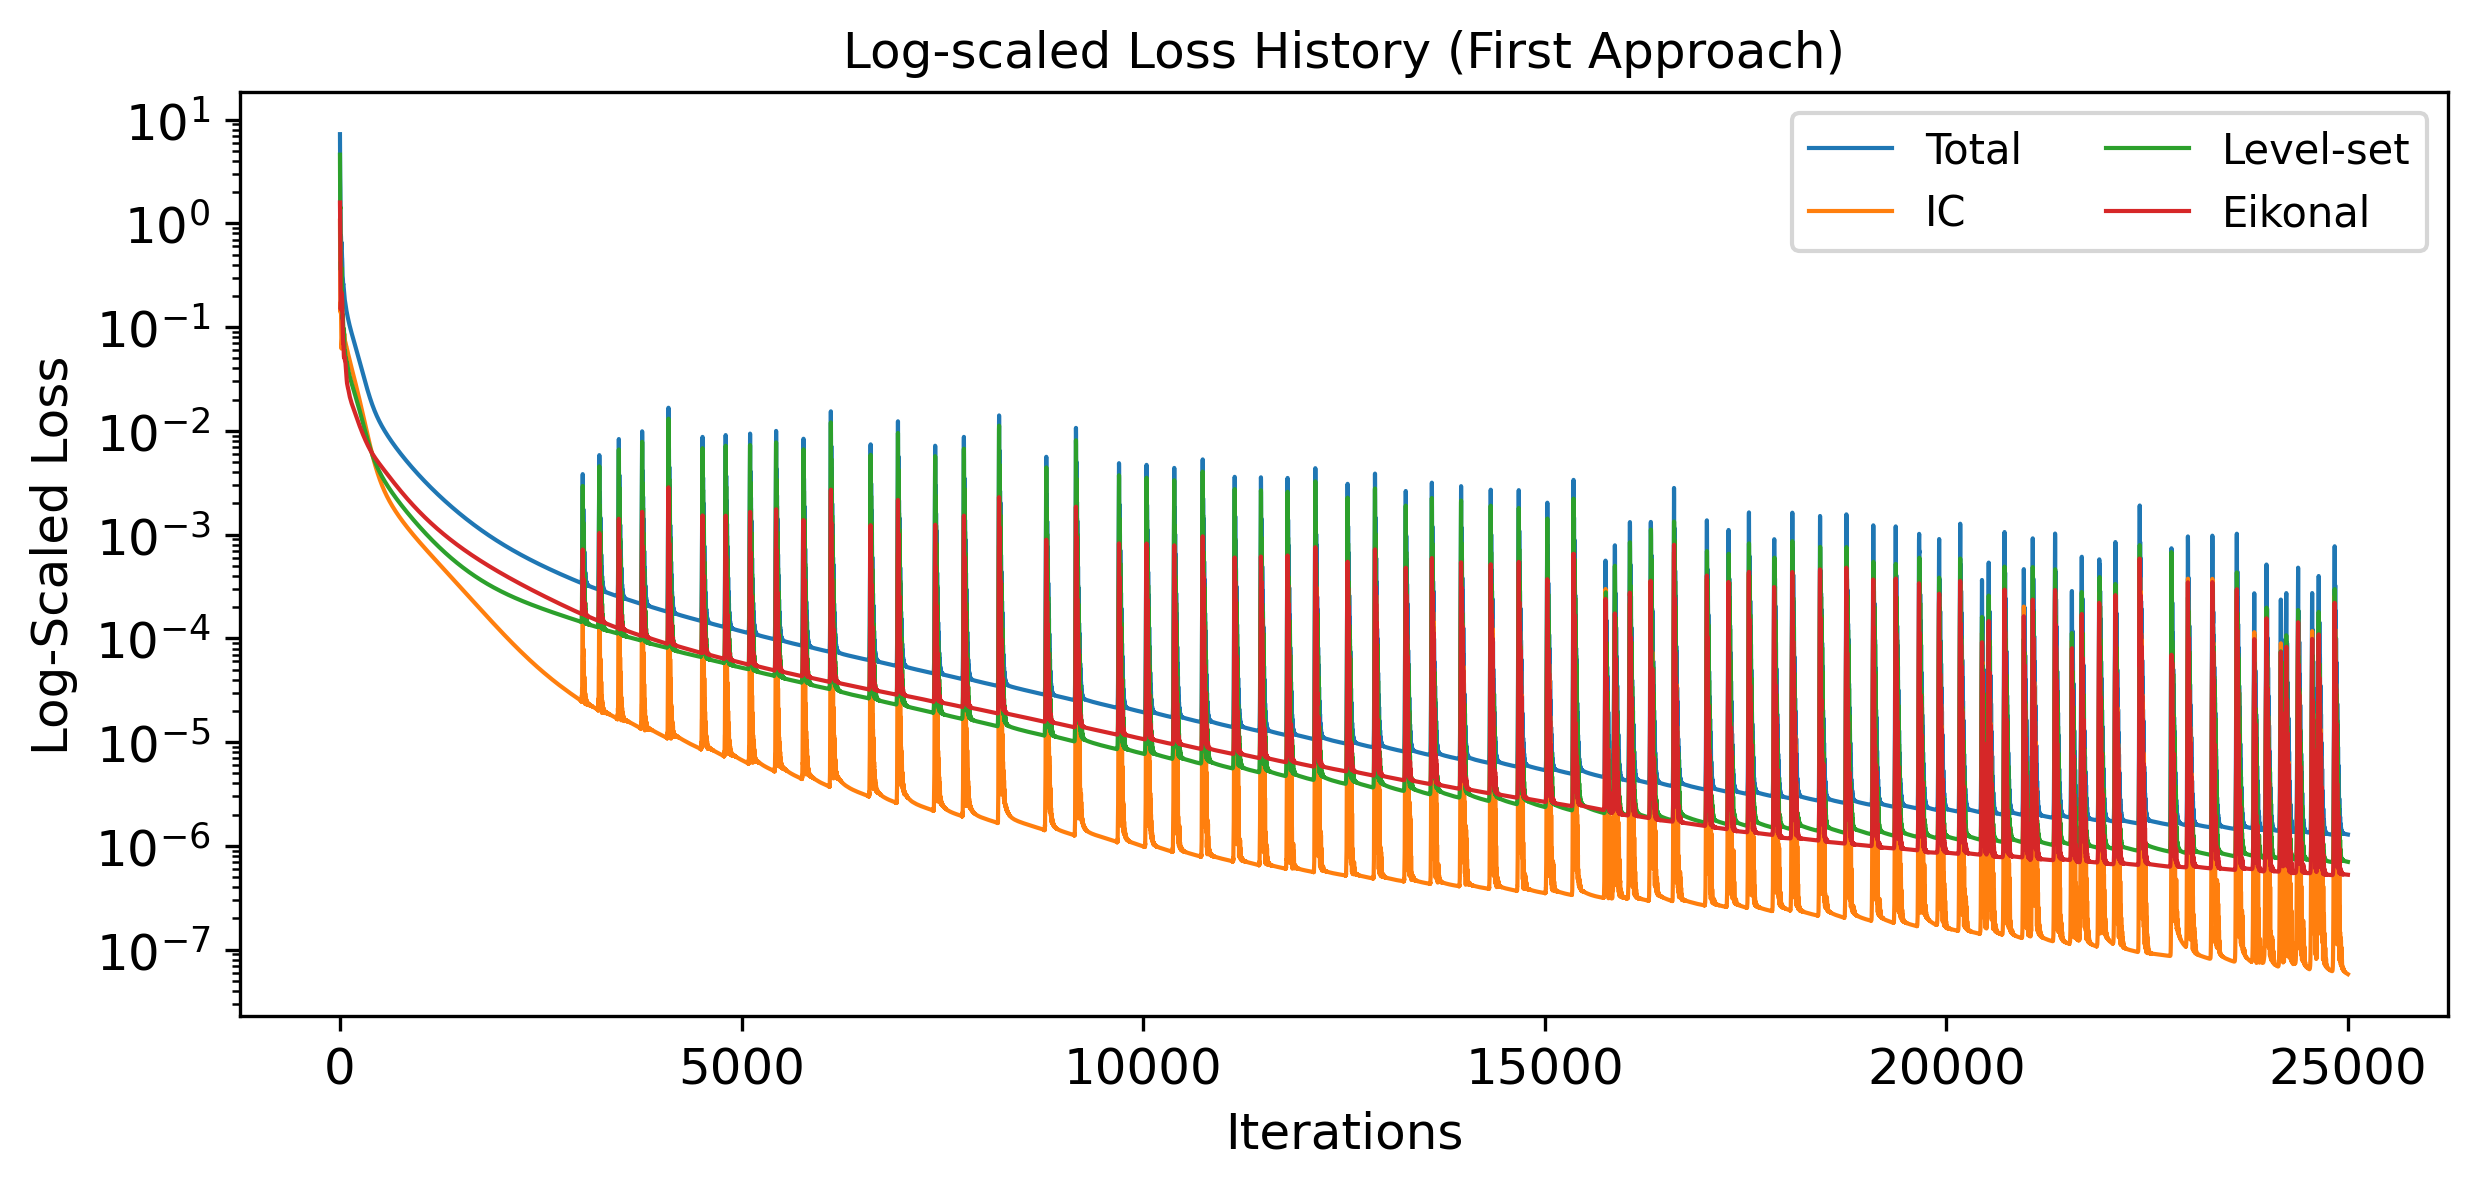

In [5]:
# Define a variable for line width
line_width = 1

# Create a plot with adjusted dimensions
fig, ax = plt.subplots(figsize=(9.5, 4))  # Width in inches to fit A4 page with 20mm margins, height adjusted as needed

# Plot each component of the loss with a logarithmic scale using the line width variable
ax.semilogy(loss_history['total_loss'], label='Total', linewidth=line_width)
ax.semilogy(loss_history['ic_loss'], label='IC', linewidth=line_width)
ax.semilogy(loss_history['level_set_loss'], label='Level-set', linewidth=line_width)
ax.semilogy(loss_history['eikonal_loss'], label='Eikonal', linewidth=line_width)

# Setting titles and labels with appropriate size
ax.set_title('Log-scaled Loss History (First Approach)', fontsize=12)
ax.set_xlabel('Iterations')
ax.set_ylabel('Log-Scaled Loss')

# Set legend with a readable size
ax.legend(fontsize=10, ncol=2)

# Save the figure with high resolution
plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/2D_LS/first_approach_training.png', bbox_inches='tight', dpi=300)

# Display the plot
plt.show()

In [4]:
pinn.load_state_dict(torch.load('./Trained Models/2D_Level_Set_Linear_First_Approach.pth'))

<All keys matched successfully>

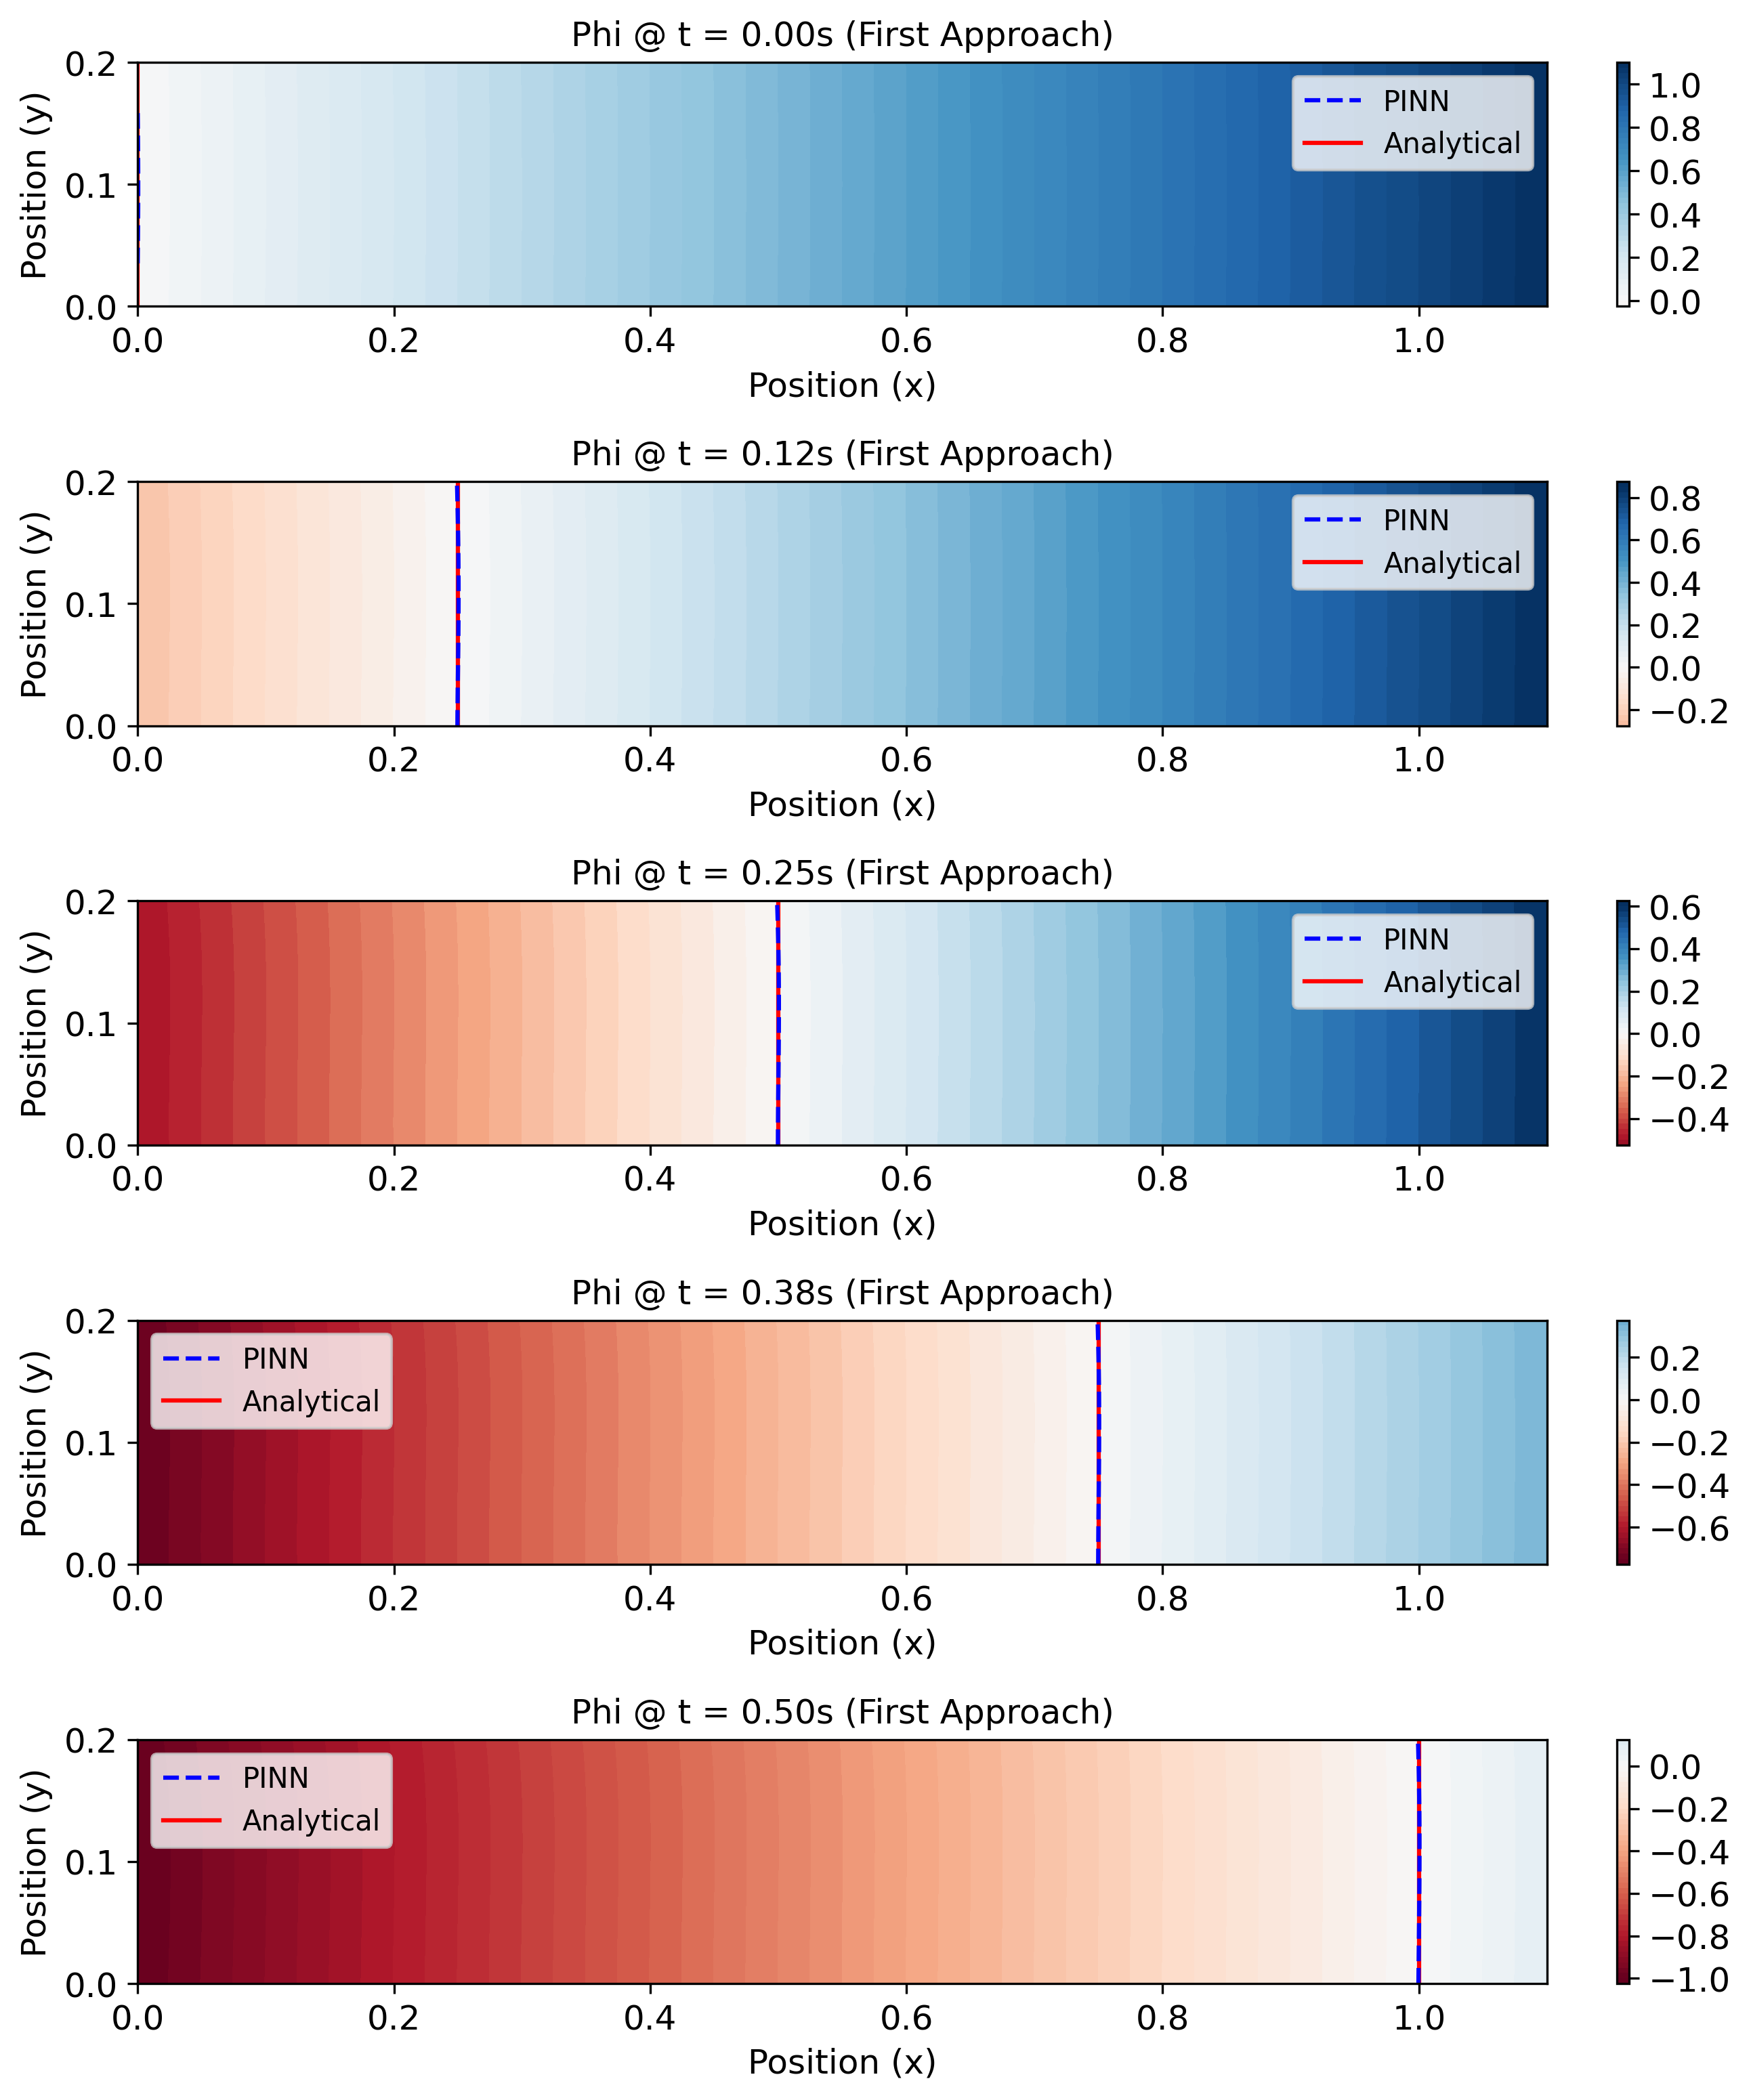

In [5]:
N_eval = 1000  # Resolution of the grid

# Generate a grid of points within the domain
x_eval = torch.linspace(0, X, N_eval).view(-1, 1)  # Space points for x
y_eval = torch.linspace(0, Y, N_eval).view(-1, 1)  # Space points for y
x_grid, y_grid = torch.meshgrid(x_eval[:, 0], y_eval[:, 0], indexing='ij')

# Select 6 evenly spaced time steps, including the start and end
time_steps = np.linspace(0, T, 5)

# Create a 2x3 subplot grid
fig, axs = plt.subplots(5, 1, figsize=(9.5, 10.5))
axs = axs.flatten()  # Flatten the 2D array of axes to make indexing easier

flow_front_positions = np.zeros(N_eval)

for i, specific_time in enumerate(time_steps):
    # Flatten the grid to pass through the network
    t_eval= torch.full_like(x_grid.reshape(-1, 1), specific_time)  # Fixed time for all points
    combined_input = torch.cat([t_eval, x_grid.reshape(-1, 1), y_grid.reshape(-1, 1)], dim=1)

    # Predict phi
    phi_pred = pinn(combined_input)
    phi_pred = phi_pred.detach().numpy().reshape(N_eval, N_eval)

    # Find the maximum absolute value in phi_values for centering the colormap
    max_abs_phi = np.max(np.abs(phi_pred))

    # Contour plot of phi values in the x-y plane at the specific time
    cs = axs[i].contourf(x_grid.numpy(), y_grid.numpy(), phi_pred, 50, cmap='RdBu', vmin=-max_abs_phi, vmax=max_abs_phi)
    axs[i].axvline(x=u*specific_time + r_in, color='red', linestyle='-', label='Analytical')
    axs[i].contour(x_grid.numpy(), y_grid.numpy(), phi_pred, levels=[0], colors='b', linestyles='--')

    # Create a color bar with fewer ticks
    cbar = fig.colorbar(cs, ax=axs[i], pad=0.04)
    cbar.locator = MaxNLocator(nbins=6)  # Reduce the number of ticks
    cbar.update_ticks()

    axs[i].set_title(f'Phi @ t = {specific_time:.2f}s (First Approach)', fontsize=12)
    axs[i].set_ylabel('Position (y)')
    axs[i].set_xlabel('Position (x)')

    # Creating custom handles for the legend
    pinn_handle = mlines.Line2D([], [], color='blue', linestyle='--', label='PINN')
    analytical_handle = mlines.Line2D([], [], color='red', linestyle='-', label='Analytical')

    if i >= 3:
        axs[i].legend(handles=[pinn_handle, analytical_handle], loc='upper left', fontsize=10)
    else:
        axs[i].legend(handles=[pinn_handle, analytical_handle], fontsize=10)
plt.tight_layout()
# Display the overall title
plt.savefig('C:/Users/lukem/OneDrive - University of Bath/FYP/Final Report/Images/2D_LS/first_approach_phi.png', bbox_inches='tight', dpi=300)
plt.show()

In [7]:
import os

# Define the directory and filename
save_dir = './Trained Models'
filename = '2D_Level_Set_Linear_First_Approach.pth'

# Check if the directory exists, if not, create it
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Path where the model will be saved
save_path = os.path.join(save_dir, filename)

# Save the model state
torch.save(pinn.state_dict(), save_path)